# MODELO: NEURAL NETWORK LSTM

## Predicción de Consumo de Agua mediante LSTM en los datos de SUB-CLUSTERING

Este notebook implementa un modelo de predicción de consumo de agua utilizando redes neuronales recurrentes LSTM (Long Short-Term Memory). El objetivo es predecir patrones de consumo de agua a nivel individual basándonos en datos agregados por sub-clusters. Los pasos a realizar son los mismos llevados a cabo con lo datos de clustering global.

### Descripción del Proceso

1. **Preparación de Datos**
   - Utilizamos datos agregados que representan las medias de consumo diario por cluster
   - Aplicamos suavizado mediante acumulado móvil de 30 días para reducir el ruido en los datos
   - Los datos se normalizan para optimizar el entrenamiento del modelo

2. **Modelado**
   - Implementación de una arquitectura LSTM
   - Entrenamiento con datos agregados por cluster
   - Validación del modelo durante el entrenamiento

3. **Evaluación**
   - Testing sobre consumidores individuales
   - Análisis del comportamiento del modelo en casos específicos
   - Métricas de rendimiento y visualización de resultados

### Objetivo
El propósito es desarrollar un modelo que, habiendo aprendido patrones generales de clusters de consumidores, sea capaz de realizar predicciones precisas a nivel individual, facilitando así la gestión y planificación del consumo de agua.

### Aplicación
Este modelo podrá ser utilizado para:
- Planificación de recursos hídricos
- Optimización de la distribución de agua
- Identificación de patrones de consumo

In [2]:
import pandas as pd
import numpy as np
import glob
import warnings
import logging
import matplotlib.pyplot as plt

# Desactiva los warnings y ajusta el logging
warnings.filterwarnings("ignore")
logging.getLogger("NP").setLevel(logging.ERROR)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

#### 1. Cargamos los datos de entrenamiento

Para esta ocasión cargaremos los datos de subclustering del cluster 1, y dentro de este sub-grupo eligerimos el cluster 0 para las pruebas.

In [5]:
# Get a list of all CSV files in the directory
csv_files = glob.glob('../predictions_dia_avg_v3/predictions_sub_1_0.csv/*.csv')

# Initialize an empty list to store individual DataFrames
dfs = []

# Loop through each CSV file and read it into a DataFrame
for file in csv_files:
    df_temp = pd.read_csv(file)
    dfs.append(df_temp)
    
# Lee todos los archivos CSV en el directorio especificado
# Almacena cada DataFrame en una lista
# Al final concatena todos los DataFrames en uno solo

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

# Optional: Reset the index of the final DataFrame
df.reset_index(drop=True, inplace=True)

df.head()

df = df.rename(columns={'day': 'ds', 'avg_all_users': 'y'})

# Asumiendo que tu DataFrame se llama 'df'

# Primero, asegúrate de que 'ds' es de tipo datetime
df['ds'] = pd.to_datetime(df['ds'])

# Luego, elimina la información de zona horaria
df['ds'] = df['ds'].dt.tz_localize(None)

# Verifica el tipo de datos de la columna 'ds'
print(df['ds'].dtype)

df.head()

datetime64[ns]


,ds,y
0,2021-01-01,0.009806
1,2021-01-02,0.009842
2,2021-01-03,0.010222
3,2021-01-04,0.010334
4,2021-01-05,0.010291


Como parte del pre-procesamiento de datos, calculamos el acumulado móvil de los datos con una ventana de 30 días y observamos como quedan los datos graficados.

In [6]:
# Creamos una columna 'acumulado_movil_30' que suma los valores de 'y' en ventanas móviles de 30 días
df['acumulado_movil_30'] = df['y'].rolling(window=30).sum()
df

,ds,y,acumulado_movil_30
0,2021-01-01,0.009806,NaN
1,2021-01-02,0.009842,NaN
2,2021-01-03,0.010222,NaN
3,2021-01-04,0.010334,NaN
4,2021-01-05,0.010291,NaN
...,...,...,...
1196,2024-04-11,0.031689,1.000588
1197,2024-04-12,0.031668,0.998528
1198,2024-04-13,0.030575,0.995175
1199,2024-04-14,0.029534,0.989564


In [7]:
# Filtramos el dataframe para quedarnos solo con datos desde el 31/01/2021 hasta el 31/12/2023 
# Eliminamos registros anteriores que tenían valores faltantes en la media acumulada
df = df[df["ds"] >= "2021-01-31 00:00:00"]
df = df[df["ds"] < "2024-01-01 00:00:00"]
df = df[df["ds"] < "2024-01-01 00:00:00"] 
df

,ds,y,acumulado_movil_30
30,2021-01-31,0.011130,0.311035
31,2021-02-01,0.010547,0.311740
32,2021-02-02,0.010533,0.312051
33,2021-02-03,0.010308,0.312025
34,2021-02-04,0.010252,0.311986
...,...,...,...
1090,2023-12-27,0.009512,0.288548
1091,2023-12-28,0.009511,0.288185
1092,2023-12-29,0.009270,0.287501
1093,2023-12-30,0.008950,0.286604


Graficamos tanto los datos originales como los datos tras aplicar el acumulado móvil con la ventana de 30 días:

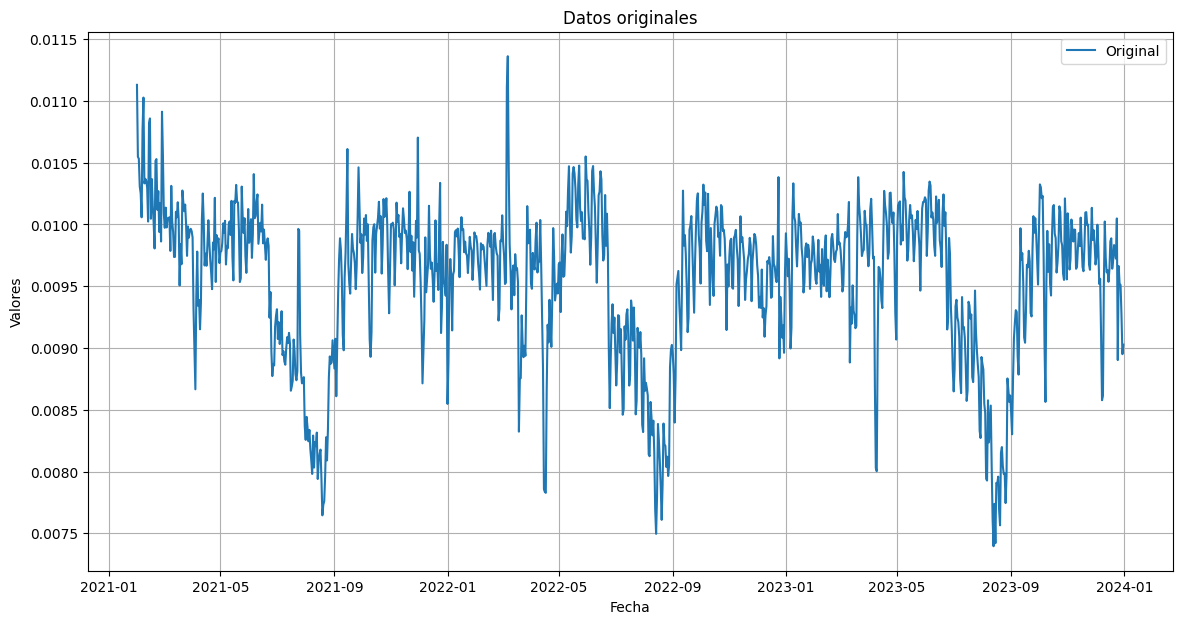

In [8]:
plt.figure(figsize=(14, 7))
plt.plot(df["ds"], df["y"], label="Original")
plt.xlabel("Fecha")
plt.ylabel("Valores")
plt.title(f"Datos originales")
plt.legend()
plt.grid()
plt.show()

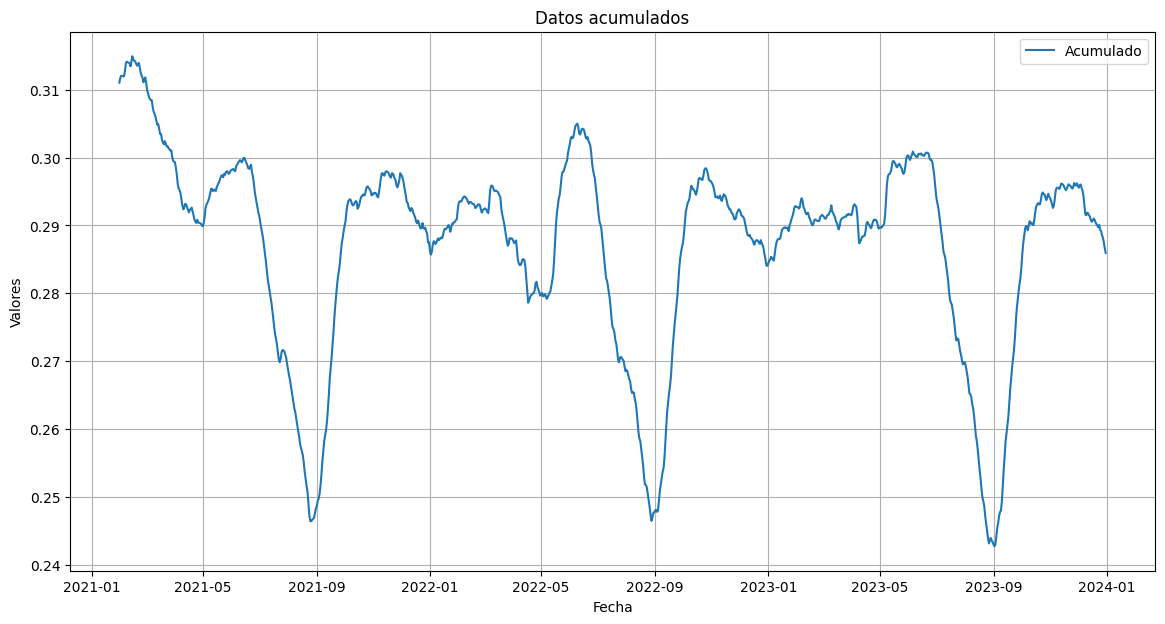

In [9]:
plt.figure(figsize=(14, 7))
plt.plot(df["ds"], df["acumulado_movil_30"], label="Acumulado")
plt.xlabel("Fecha")
plt.ylabel("Valores")
plt.title(f"Datos acumulados")
plt.legend()
plt.grid()
plt.show()

In [10]:
# Eliminamos la columna 'y' original
df = df.drop(columns=['y'])
# Renombramos la columna 'acumulado_movil_30' a 'y'
df = df.rename(columns={'acumulado_movil_30': 'y'})

# Mostramos el dataframe resultante
df

,ds,y
30,2021-01-31,0.311035
31,2021-02-01,0.311740
32,2021-02-02,0.312051
33,2021-02-03,0.312025
34,2021-02-04,0.311986
...,...,...
1090,2023-12-27,0.288548
1091,2023-12-28,0.288185
1092,2023-12-29,0.287501
1093,2023-12-30,0.286604


Dividimos los datos en train y test para el entrenamiento y las posteriores pruebas de funcionamiento y los mostramos:

In [11]:
# Divide los datos en conjuntos de entrenamiento y prueba
# Los datos anteriores a junio 2023 son para entrenamiento
df_data_train = df[df["ds"] < "2023-06-01 00:00:00"] # segunda opción temporal --> 2024-01-01 00:00:00

# Los datos desde junio 2023 hasta diciembre 2023 son para pruebas
df_data_test = df[df["ds"] >= "2023-06-01 00:00:00"]
df_data_test = df_data_test[df_data_test["ds"] < "2024-01-01 00:00:00"]


# Muestra el conjunto de datos de prueba
df_data_test

,ds,y
881,2023-06-01,0.300323
882,2023-06-02,0.299895
883,2023-06-03,0.299649
884,2023-06-04,0.300086
885,2023-06-05,0.300435
...,...,...
1090,2023-12-27,0.288548
1091,2023-12-28,0.288185
1092,2023-12-29,0.287501
1093,2023-12-30,0.286604


In [12]:
df_data_train

,ds,y
30,2021-01-31,0.311035
31,2021-02-01,0.311740
32,2021-02-02,0.312051
33,2021-02-03,0.312025
34,2021-02-04,0.311986
...,...,...
876,2023-05-27,0.297596
877,2023-05-28,0.297950
878,2023-05-29,0.298847
879,2023-05-30,0.299961


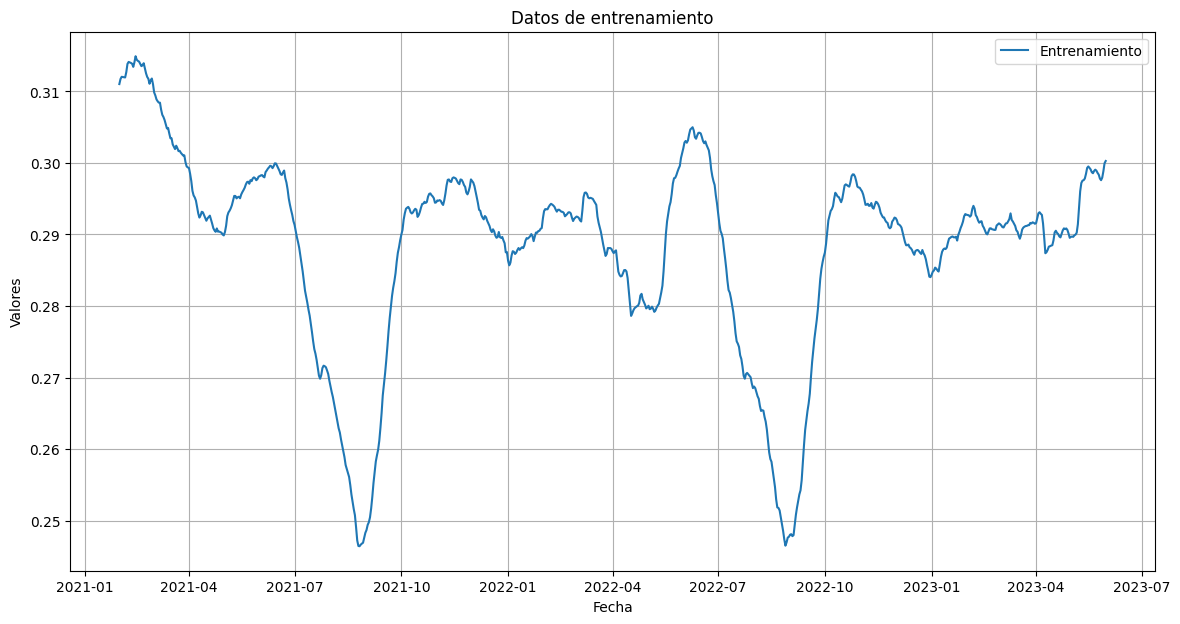

In [13]:
plt.figure(figsize=(14, 7))
plt.plot(df_data_train["ds"], df_data_train["y"], label="Entrenamiento")
plt.xlabel("Fecha")
plt.ylabel("Valores")
plt.title(f"Datos de entrenamiento")
plt.legend()
plt.grid()
plt.show()

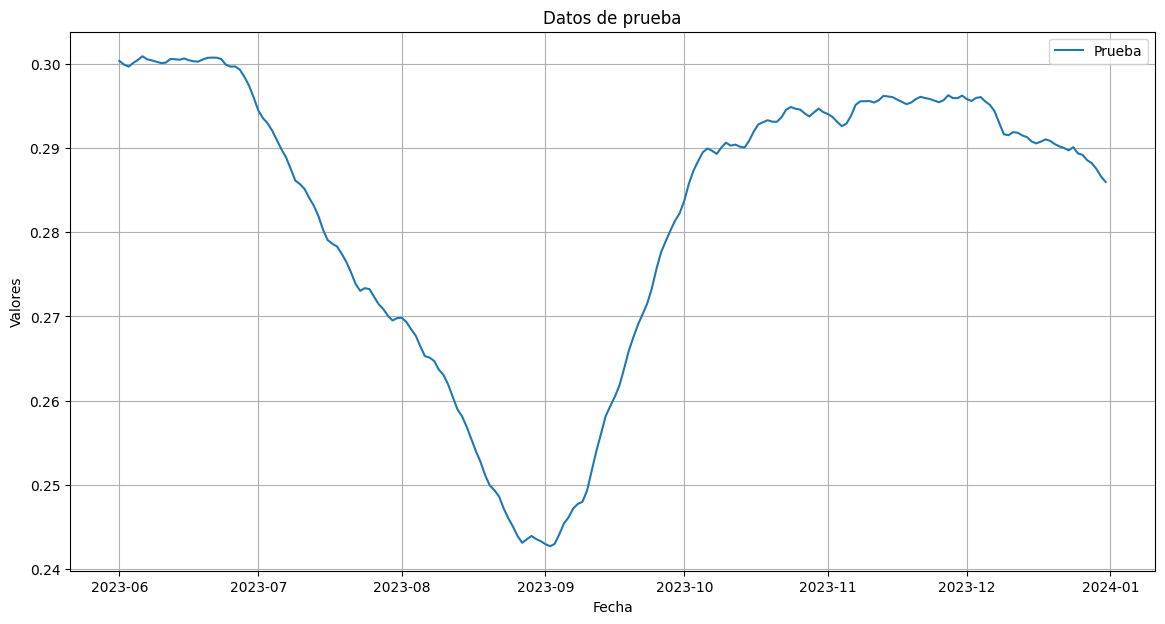

In [14]:
plt.figure(figsize=(14, 7))
plt.plot(df_data_test["ds"], df_data_test["y"], label="Prueba")
plt.xlabel("Fecha")
plt.ylabel("Valores")
plt.title(f"Datos de prueba")
plt.legend()
plt.grid()
plt.show()

#### 2. Preparación de los datos para el modelo LSTM

Para entrenar el modelo LSTM, dividiremos el conjunto de datos en secuencias temporales: utilizaremos ventanas de 60 días como datos de entrada para predecir los siguientes 30 días (un mes). Esta estructura permitirá que el modelo capture patrones estacionales y tendencias en los datos históricos para realizar predicciones más precisas.


In [15]:
# Leemos los datos desde el dataframe de entrenamiento
data = df_data_train

# Escalamos los datos entre 0 y 1 usando MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['y']])
data['y_scaled'] = data_scaled

# Función para crear secuencias de entrada y salida usando ventanas deslizantes
def create_sequences(data, input_steps, output_steps):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps + 1):
        # La secuencia de entrada son los input_steps anteriores
        X.append(data[i:i + input_steps])
        # La secuencia de salida son los output_steps siguientes
        y.append(data[i + input_steps:i + input_steps + output_steps]) 
    return np.array(X), np.array(y)

# Definimos el tamaño de las ventanas de entrada y salida
input_steps = 60  # Ventana de entrada de 60 días (2 meses)
output_steps = 30  # Ventana de predicción de 30 días (1 mes)

# Generamos las secuencias de entrada X y salida y
X, y = create_sequences(data_scaled, input_steps, output_steps)

# Dividimos los datos en conjuntos de entrenamiento (80%) y prueba (20%) de forma aleatoria
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
data

,ds,y,y_scaled
30,2021-01-31,0.311035,0.943163
31,2021-02-01,0.311740,0.953461
32,2021-02-02,0.312051,0.957994
33,2021-02-03,0.312025,0.957613
34,2021-02-04,0.311986,0.957043
...,...,...,...
876,2023-05-27,0.297596,0.747035
877,2023-05-28,0.297950,0.752213
878,2023-05-29,0.298847,0.765290
879,2023-05-30,0.299961,0.781557


#### 3. Entrenamiento de un modelo básico

In [17]:
# Inicializamos un modelo secuencial para la red neuronal LSTM
# La arquitectura consiste en una capa LSTM seguida de una capa densa
model = Sequential([
    # Capa LSTM con 64 unidades, función de activación ReLU
    # input_shape especifica la forma de entrada: (pasos_temporales, características)
    # return_sequences=False para obtener solo la última salida
    LSTM(64, activation='relu', input_shape=(input_steps, 1), return_sequences=False),
    
    # Capa densa de salida con tantas unidades como días queremos predecir
    Dense(output_steps)  
])

# Configuración del proceso de entrenamiento
# Optimizador Adam y error cuadrático medio (MSE) como función de pérdida
model.compile(optimizer='adam', loss='mse')

# Entrenamiento del modelo con los datos
# X_train: datos de entrenamiento, y_train.squeeze(): etiquetas sin dimensión extra
# validation_data: datos de prueba para validación
# epochs: número de iteraciones completas sobre el conjunto de datos
# batch_size: tamaño del lote de datos procesados en cada iteración
history = model.fit(
    X_train, y_train.squeeze(),
    validation_data=(X_test, y_test.squeeze()),
    epochs=20,
    batch_size=32,
    verbose=1
)

2024-12-03 11:56:37.111732: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.3516 - val_loss: 0.2004
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1417 - val_loss: 0.0632
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0569 - val_loss: 0.0258
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0279 - val_loss: 0.0195
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0234 - val_loss: 0.0177
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0196 - val_loss: 0.0173
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0211 - val_loss: 0.0170
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0197 - val_loss: 0.0165
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0193 - val_loss: 0.0156
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0190 - val_loss: 0.0158
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0174 - val_loss: 0.0155
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0

#### 3.1 Evaluación

In [18]:
# Cálculo de predicciones para el set de testing
y_pred = model.predict(X_test)

# Deshacemos la normalización de los datos 
y_test_inverse = scaler.inverse_transform(y_test.squeeze())
y_pred_inverse = scaler.inverse_transform(y_pred)

# Evaluación del rendimiento del modelo mediante diferentes métricas de error
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
mape = np.mean(np.abs((y_test_inverse - y_pred_inverse) / y_test_inverse)) * 100

# Visualización de las métricas de error obtenidas
print(f"MAE: {mae:.4f}")  # Error medio absoluto
print(f"RMSE: {rmse:.4f}")  # Raíz del error cuadrático medio  
print(f"MAPE: {mape:.2f}%") # Error porcentual medio absoluto


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
MAE: 0.0053
RMSE: 0.0078
MAPE: 1.92%


#### 3.2 Interpretación de las métricas
- MAE (Mean Absolute Error):

Representa el error promedio en unidades del objetivo (en este caso, la escala de consumo de agua).
Ejemplo: Un MAE de 0.5 significa que las predicciones tienen un error promedio de 0.5 unidades.

- RMSE (Root Mean Squared Error):

Similar al MAE, pero penaliza más los errores grandes.
Un RMSE más alto que el MAE indica que hay outliers o errores grandes en algunas predicciones.

- MAPE (Mean Absolute Percentage Error):

Representa el error como un porcentaje del valor real.
Ejemplo: Un MAPE de 5% indica que las predicciones son, en promedio, un 5% diferentes de los valores reales.


Graficación de los resultados de las predicciones sobre el conjunto de prueba:

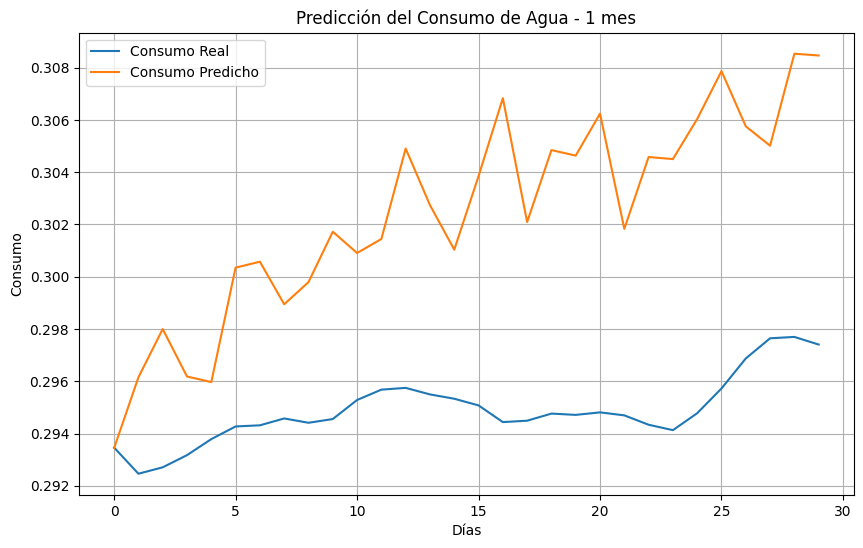

In [20]:
# Graficar resultados de consumo de agua (opcional)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse[0], label="Consumo Real")
plt.plot(y_pred_inverse[0], label="Consumo Predicho") 
plt.title("Predicción del Consumo de Agua - 1 mes")
plt.xlabel("Días")
plt.ylabel("Consumo")
plt.legend()
plt.grid()
plt.show()


#### 4. CrossValidation 

La validación cruzada (cross-validation) es una técnica de evaluación del modelo que nos permite:

- Dividir el conjunto de datos en 5 partes o "folds" iguales
- Entrenar el modelo LSTM usando 4 folds para entrenamiento y 1 fold para validación
- Repetir el proceso 5 veces rotando el fold de validación
- Obtener 5 métricas de evaluación diferentes (una por cada iteración)
- Calcular la media y desviación estándar de las métricas

Esto nos ayuda a:
- Evaluar la robustez y estabilidad del modelo 
- Detectar posible sobreajuste
- Tener una estimación más confiable del rendimiento real
- Aprovechar mejor los datos disponibles

En el caso del modelo LSTM, es especialmente útil ya que:
- Las redes neuronales son sensibles a la inicialización aleatoria
- Necesitamos validar la capacidad de generalización
- Podemos ajustar hiperparámetros comparando resultados
- Evitamos sesgos por la división train/test


In [21]:
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Configuración de TimeSeriesSplit
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Listas para almacenar métricas
mae_list, rmse_list, mape_list = [], [], []

# Validación cruzada
for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {fold + 1}/{n_splits}")
    
    # Dividir datos en entrenamiento y prueba
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Construcción del modelo LSTM
    model = Sequential([
        LSTM(64, activation='tanh', input_shape=(input_steps, 1), return_sequences=False),
        Dense(output_steps)
    ])
    model.compile(optimizer='adam', loss='mse')
    
    # Entrenamiento del modelo
    model.fit(X_train, y_train.squeeze(), epochs=10, batch_size=32, verbose=0)
    
    # Predicción
    y_pred = model.predict(X_test)
    
    # Inversión del escalado
    y_test_inverse = scaler.inverse_transform(y_test.squeeze())
    y_pred_inverse = scaler.inverse_transform(y_pred)
    
    # Cálculo de métricas
    mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
    rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
    mape = np.mean(np.abs((y_test_inverse - y_pred_inverse) / y_test_inverse)) * 100
    
    # Almacenar métricas
    mae_list.append(mae)
    rmse_list.append(rmse)
    mape_list.append(mape)
    
    print(f"Fold {fold + 1} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")

# Promediar métricas
print("\n--- Resultados Promediados ---")
print(f"MAE Promedio: {np.mean(mae_list):.4f}")
print(f"RMSE Promedio: {np.mean(rmse_list):.4f}")
print(f"MAPE Promedio: {np.mean(mape_list):.2f}%")


Fold 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Fold 1 - MAE: 0.0125, RMSE: 0.0154, MAPE: 4.44%
Fold 2/5
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/stepWARNING:tensorflow:6 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f08f4674c20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Fold 2 - MAE: 0.0036, RMSE: 0.0043, MAPE: 1.26%
Fold 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Fol

Entrenamos de nuevo un modelo final con todos los datos de entrenamiento, y ajustamos los diferentes parámetros como estaban anteriormente:

In [22]:
# Entrenamiento final con todos los datos de entrenamiento
model_final = Sequential([
    LSTM(64, activation='tanh', input_shape=(input_steps, 1), return_sequences=False),
    Dense(output_steps)
])
model_final.compile(optimizer='adam', loss='mse')

# Entrenar el modelo final con los datos de entrenamiento completos
model_final.fit(
    X, y.squeeze(),
    validation_split=0.2,  # Validación durante el entrenamiento para verificar sobreajuste
    epochs=50,             # Incrementamos los epochs para capturar patrones más complejos
    batch_size=32,
    verbose=1
)

Epoch 1/50


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.3321 - val_loss: 0.0769
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0656 - val_loss: 0.0053
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0342 - val_loss: 0.0049
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0305 - val_loss: 0.0029
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0316 - val_loss: 0.0030
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0255 - val_loss: 0.0069
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0253 - val_loss: 0.0058
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0245 - val_loss: 0.0035
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0205 - val_loss: 0.0149
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0240 - val_loss: 0.0026
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0175 - val_loss: 0.0128
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0192 - val_l

#### 5. Testing con un usuario individual: Predicción del consumo utilizando LSTM
El modelo LSTM entrenado previamente se usará para predecir el consumo específico de un usuario seleccionado, analizando sus patrones individuales de forma aislada.


In [33]:
# Get a list of all CSV files in the directory
csv_files = glob.glob('../data_testing/cluster_sub1_0_sum_V3.csv/*.csv')

# Initialize an empty list to store individual DataFrames
dfs = []

# Loop through each CSV file and read it into a DataFrame
for file in csv_files:
    df_temp = pd.read_csv(file)
    dfs.append(df_temp)

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

# Optional: Reset the index of the final DataFrame
df.reset_index(drop=True, inplace=True)

df_users = df.rename(columns={'day': 'ds', 'sum_value': 'y'})

# Asumiendo que tu DataFrame se llama 'df'

# Primero, asegúrate de que 'ds' es de tipo datetime
df_users['ds'] = pd.to_datetime(df_users['ds'])

# Luego, elimina la información de zona horaria
df_users['ds'] = df_users['ds'].dt.tz_localize(None)

# Verifica el tipo de datos de la columna 'ds'
print(df_users['ds'].dtype)

# df_users = df_users.sort_values('ds')

df_users.head()

datetime64[ns]


,ds,serial_number,y
0,2023-09-08,J18YA010527,0.150
1,2023-09-08,J18YA010531,0.212
2,2023-09-08,J18YA010533,0.083
3,2023-09-08,J18YA010535,0.037
4,2023-09-08,J18YA010537,0.176


Elegimos al azar un usuario concreto:

In [34]:
# Filtrar por serial_number de interés
serial_to_predict = "J18YA010535"  # Serial que quieres predecir 
df_filtered = df_users[df_users['serial_number'] == serial_to_predict]
df_filtered = df_filtered.sort_values('ds')
df_filtered.head()

,ds,serial_number,y
2476609,2023-01-01,J18YA010535,0.186
2479055,2023-01-02,J18YA010535,0.303
2481501,2023-01-03,J18YA010535,0.320
2483947,2023-01-04,J18YA010535,0.300
2486393,2023-01-05,J18YA010535,0.224


In [ ]:
# df_filtered['acumulado_movil_30'] = df_filtered['y'].rolling(window=30).sum()
# df_filtered = df_filtered.drop(columns=['y'])
# df_filtered = df_filtered.rename(columns={'acumulado_movil_30': 'y'})

Dividimos los datos en train y test siguiendo las mismas fechas que se habían utilizado anteriormente, con el objetivo de predecir sobre datos de test individuales no vistos por el modelo durante su entrenamiento:

In [35]:
df_data_train_filter = df_filtered[df_filtered["ds"] < "2023-07-01"]
df_data_test_filter = df_filtered[df_filtered["ds"] >= "2023-07-01"]
df_data_test_filter = df_data_test_filter[df_data_test_filter["ds"] < "2024-01-01"]

In [36]:
df_data_test_filter

,ds,serial_number,y
2120191,2023-07-01,J18YA010535,0.000
2122635,2023-07-02,J18YA010535,0.000
2125080,2023-07-03,J18YA010535,0.000
2127518,2023-07-04,J18YA010535,0.112
2129952,2023-07-05,J18YA010535,0.000
...,...,...,...
268296,2023-12-27,J18YA010535,0.269
270734,2023-12-28,J18YA010535,0.247
273177,2023-12-29,J18YA010535,0.245
275619,2023-12-30,J18YA010535,0.162


Preparamos los datos en secuencias para poder obtener predicciones de nuestro modelo entrenado:

In [37]:
def create_sequences(data, input_steps, output_steps):
    X, y = [], []
    for i in range(len(data) - input_steps):
        # Obtención de la secuencia de entrada
        X_seq = data[i:i + input_steps]
        
        # Obtención de la secuencia de salida, con relleno de ceros si es necesario
        y_seq = data[i + input_steps:i + input_steps + output_steps]
        
        # Rellenar con ceros si no hay suficientes datos en la secuencia de salida
        if len(y_seq) < output_steps:
            y_seq = np.pad(y_seq, (0, output_steps - len(y_seq)), mode='constant', constant_values=0)
        
        X.append(X_seq)
        y.append(y_seq)
    
    return np.array(X), np.array(y)

# Configuración de las ventanas
input_steps = 30  # Por ejemplo, 60 días de entrada
output_steps = 30  # Por ejemplo, 30 días de salida

# Usamos solo la columna 'y' para las predicciones
X_test, y_test = create_sequences(df_data_test_filter['y'].values, input_steps, output_steps)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_test: (154, 30, 1), y_test: (154, 30)


In [38]:
# Realizamos las predicciones con el modelo LSTM
y_pred = model_final.predict(X_test)

# Desescalar las predicciones y los valores reales
y_test_unscaled = scaler.inverse_transform(y_test)  # Desescalar los valores reales
y_pred_unscaled = scaler.inverse_transform(y_pred)  # Desescalar las predicciones

# Calcular métricas de evaluación
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
mape = mean_absolute_percentage_error(y_test_unscaled, y_pred_unscaled) * 100

# Imprimir métricas
print(f"Conjunto de Prueba - MAE: {mae:.4f}")
print(f"Conjunto de Prueba - RMSE: {rmse:.4f}")
print(f"Conjunto de Prueba - MAPE: {mape:.2f}%")



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Conjunto de Prueba - MAE: 0.0194
Conjunto de Prueba - RMSE: 0.0227
Conjunto de Prueba - MAPE: 7.57%


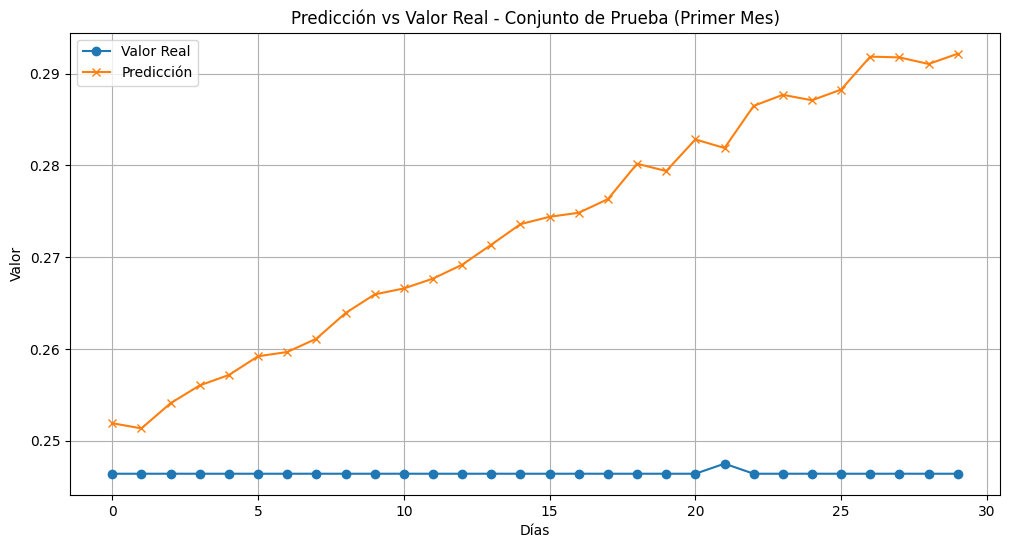

In [39]:
# Graficar los resultados
import matplotlib.pyplot as plt

# Graficar las predicciones y los valores reales del primer segmento del conjunto de prueba
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled[0], label="Valor Real", marker='o')
plt.plot(y_pred_unscaled[0], label="Predicción", marker='x')
plt.title("Predicción vs Valor Real - Conjunto de Prueba (Primer Mes)")
plt.xlabel("Días")
plt.ylabel("Valor")
plt.legend()
plt.grid()
plt.show()

In [40]:
len(y_pred_unscaled)

154

In [41]:
len(y_test_unscaled)

154

El vector que obtenemos de las predicciones contiene diferentes valores, cada uno de ellos es una predicción, por lo que podemos graficar la media de dichos resultados para ver como se comporta nuestro modelo y calcular el error

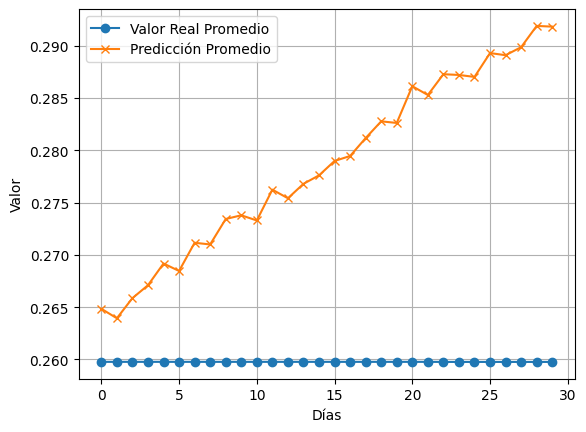

In [42]:
mean_real = np.mean(y_test_unscaled, axis=0)  # Promedio diario real
mean_pred = np.mean(y_pred_unscaled, axis=0)  # Promedio diario predicho

plt.plot(mean_real, label="Valor Real Promedio", marker='o')
plt.plot(mean_pred, label="Predicción Promedio", marker='x')
plt.legend()
plt.xlabel("Días")
plt.ylabel("Valor")
plt.grid()
plt.show()

In [43]:
# Calcular métricas
mae = mean_absolute_error(mean_real, mean_pred)
rmse = np.sqrt(mean_squared_error(mean_real, mean_pred))
mape = np.mean(np.abs((mean_real - mean_pred) / mean_real)) * 100

# Imprimir resultados
print(f"Error promedio diario:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

Error promedio diario:
MAE: 0.0188
RMSE: 0.0207
MAPE: 7.25%
